In [1]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from os import listdir

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve


from main import df_scrolling_object

import my_func
import importlib
# importlib.reload(main)
importlib.reload(my_func)

from pandas_profiling import ProfileReport

In [2]:
data_train = pd.read_csv('kaggle/train.csv')
data_subm = pd.read_csv('kaggle/sample_submission.csv')
data_test = pd.read_csv('kaggle/test.csv')
data_train['train'] = 1 # помечаем где у нас трейн
data_test['train'] = 0 # помечаем где у нас тест
data = data_train.append(data_test, sort=False).reset_index(drop=True)

In [3]:
bin_cols = ['good_work', 'foreign_passport', 'car', 'car_type', 'sex' ]
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki']
cat_cols = ['education', 'home_address' , 'work_address', 'first_time', 'sna' , 'region_rating']

In [4]:
# переведем признак data.score_bki к положительным значениям, чтобы проще можно было логорифмировать
data.score_bki = data.score_bki - data.score_bki.min() 

In [5]:
edu_income_rel = dict({'SCH': list([0, 31960.275039]),
                       'UGR': list([31960.275039,39391.796251]),
                       'GRD': list([39391.796251, 54663.948941]),
                       'PGR': list([54663.948941, 77548.206046]),
                       'ACD': list([77548.206046, 999999999999])})
def fill_edu(income, edu_income_rel):
    for edu, income_edu in edu_income_rel.items():
         if income_edu[0] < income <  income_edu[1]:
             return edu
na_index = data[data.education.isna()].index
data.loc[data['education'].isna(), 'education'] = data[data.education.isna()].income.apply(lambda x: fill_edu(x, edu_income_rel))

In [6]:
data.app_date = pd.to_datetime(data.app_date)
data['month'] = data.app_date.dt.month
data['day'] = data.app_date.dt.day
data['year'] = data.app_date.dt.year

last_date = set()
data['app_date_diff_today'] = pd.datetime.today() - data.app_date
data['app_date_diff_today'] = data['app_date_diff_today'].dt.days

data.drop(['app_date'], axis=1, inplace=True)

In [7]:
edu_dict = dict({'SCH': 0, #school
                 'GRD': 1, #out-student
                 'UGR': 2, #student
                 'PGR': 3, #aspirant
                 'ACD': 4})#academic 

# data['education_lvl'] = data['education'].map(edu_dict)
# data['education'] = data['education'].map(edu_dict)
# data['education'] = data['education'].astype('category').cat.codes#
data['education'] = data['education'].map(edu_dict)

In [8]:
# label_encoder = LabelEncoder()

# for bin_col in bin_cols:
#     data[bin_col] = label_encoder.fit_transform(data[bin_col])

# PROFILER

In [ ]:
# profile = ProfileReport(data)
# profile.to_widgets()

# Изучение NaN

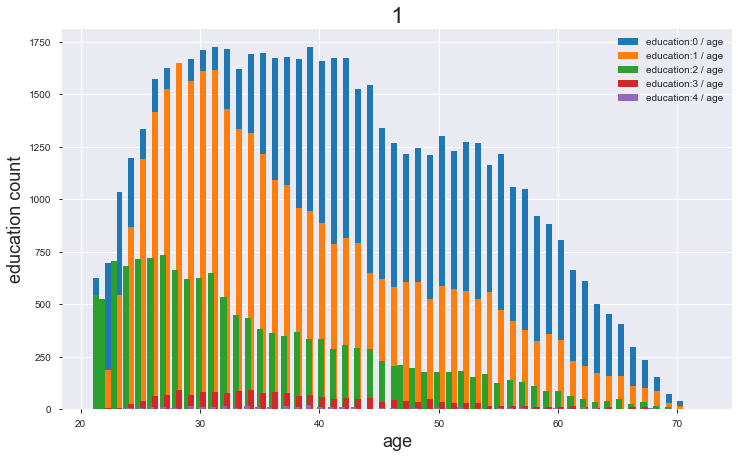

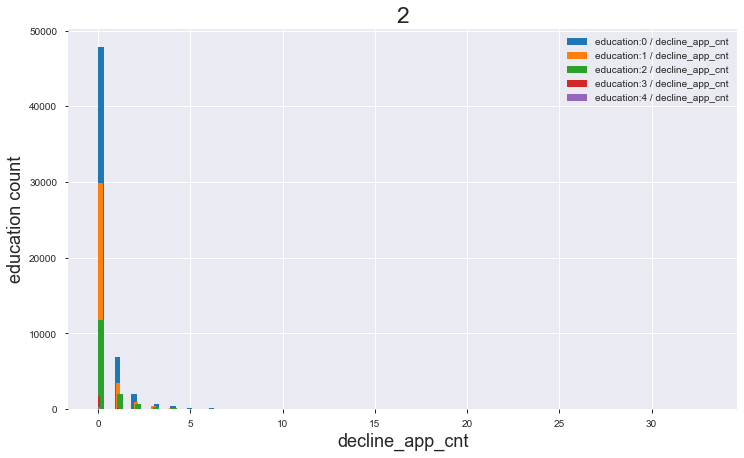

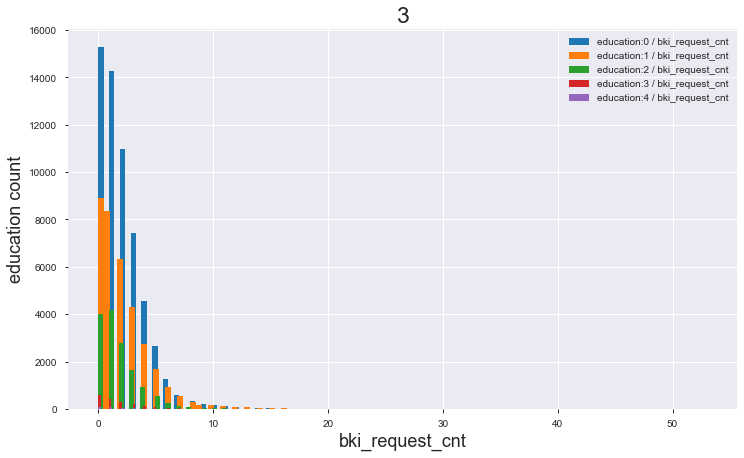

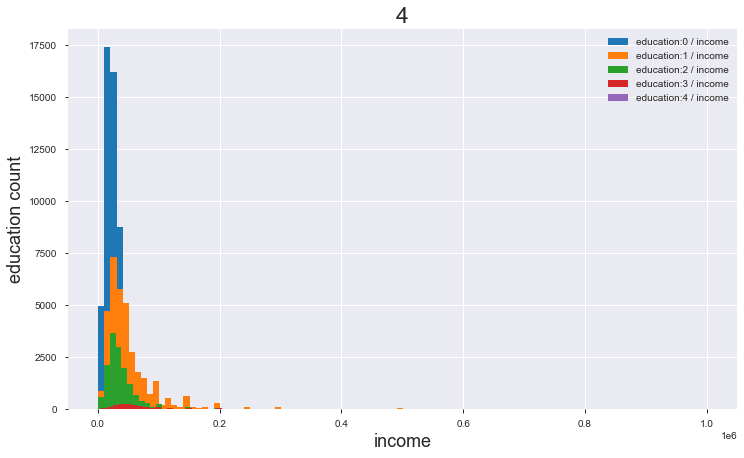

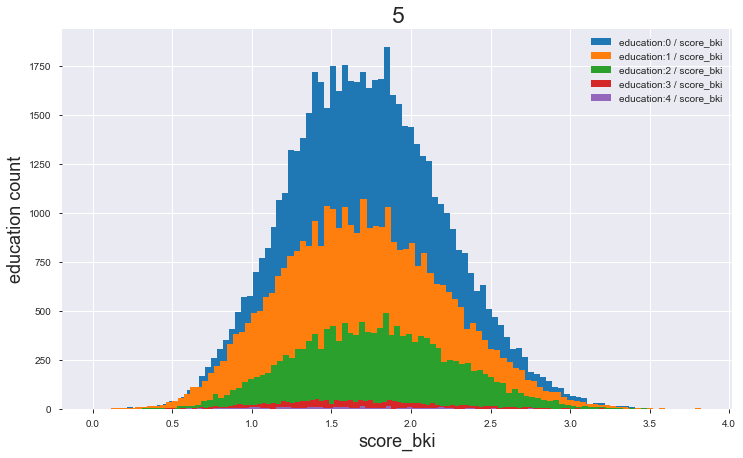

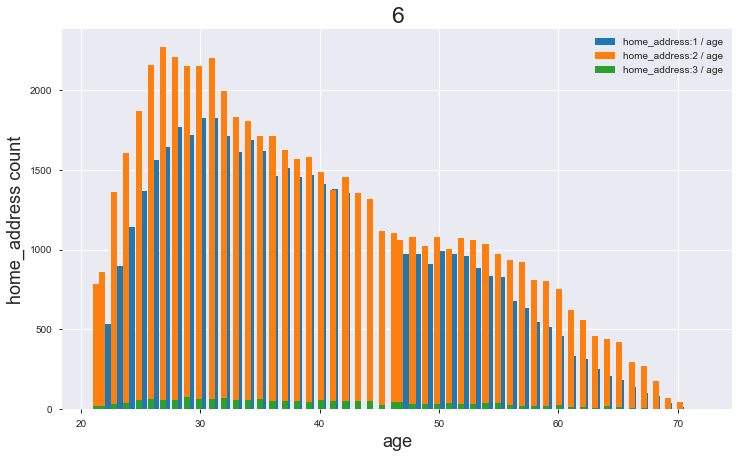

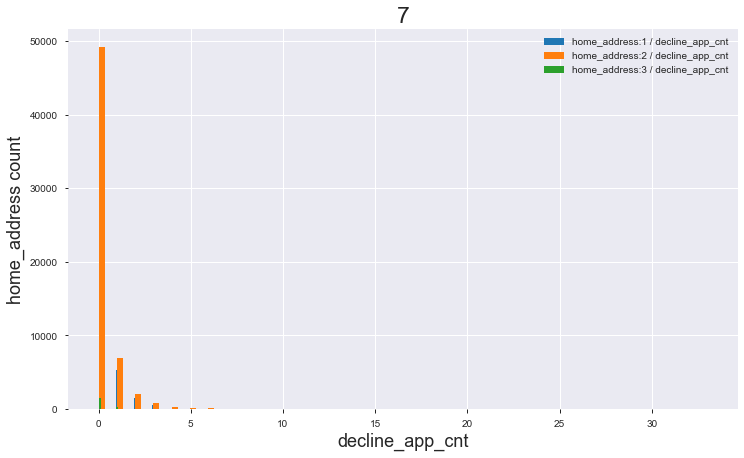

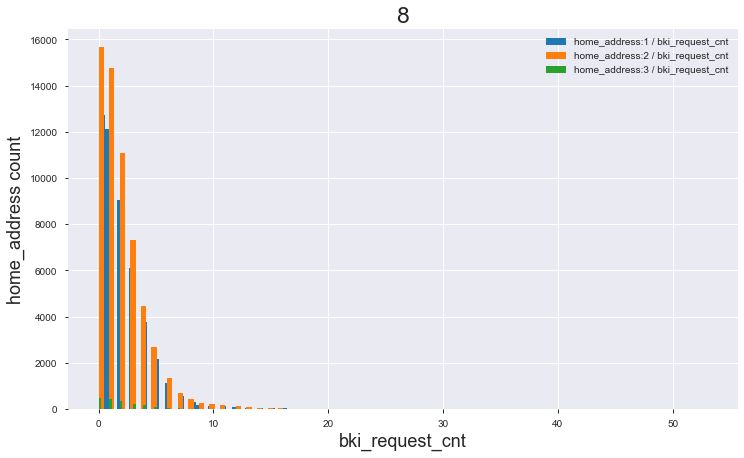

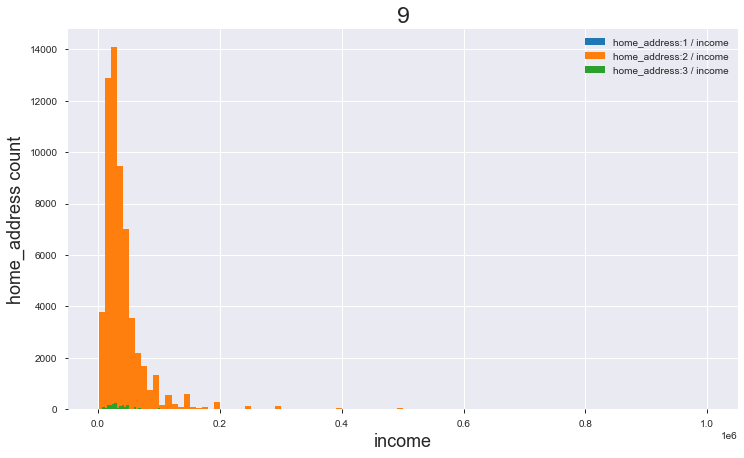

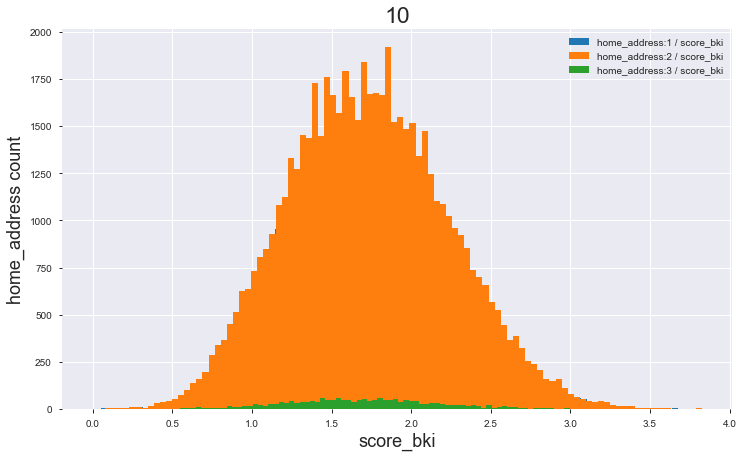

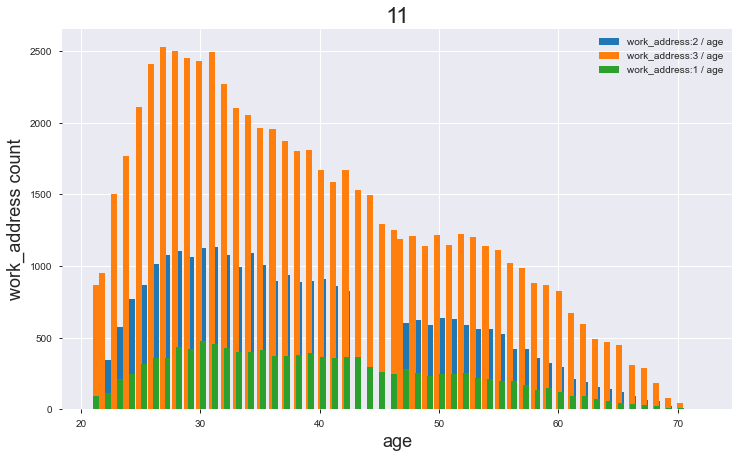

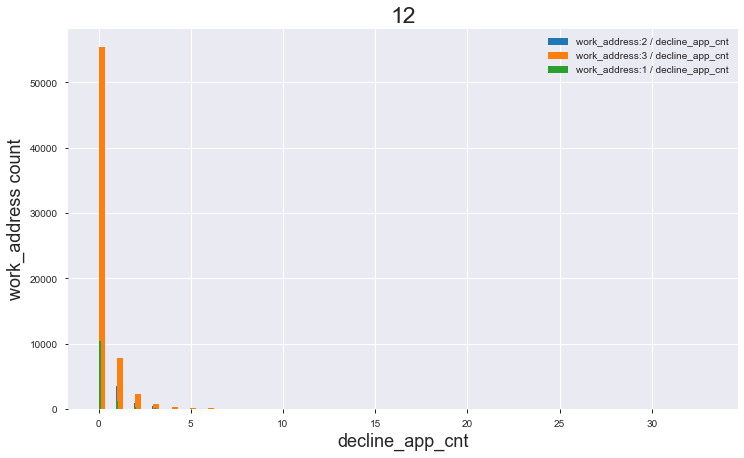

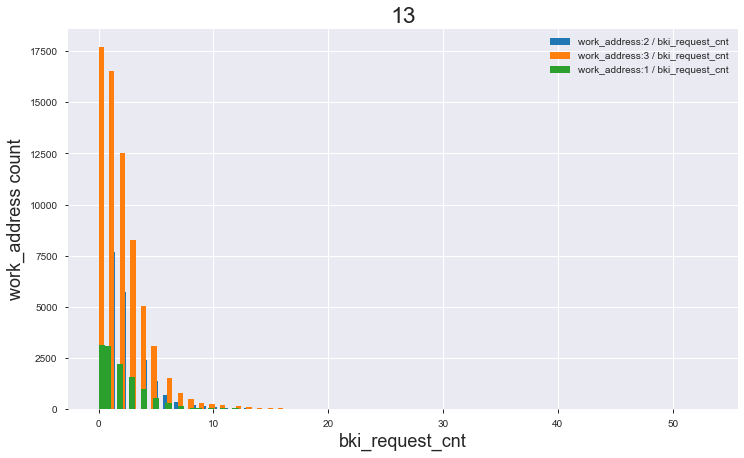

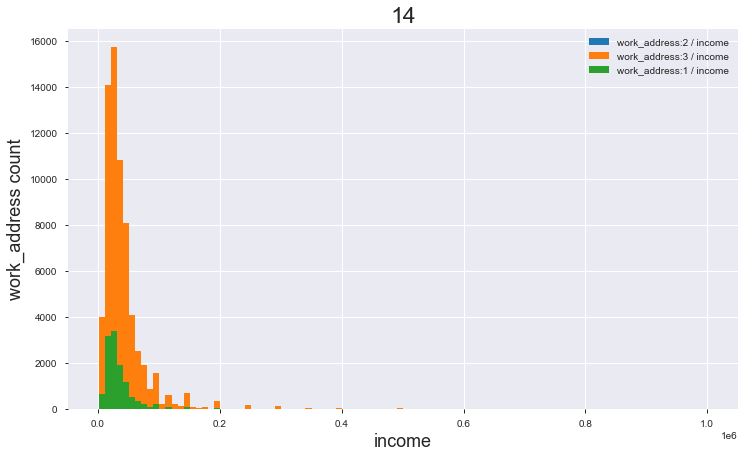

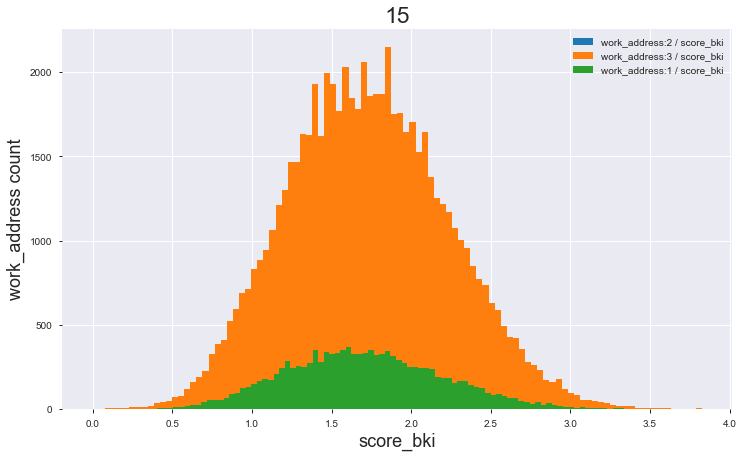

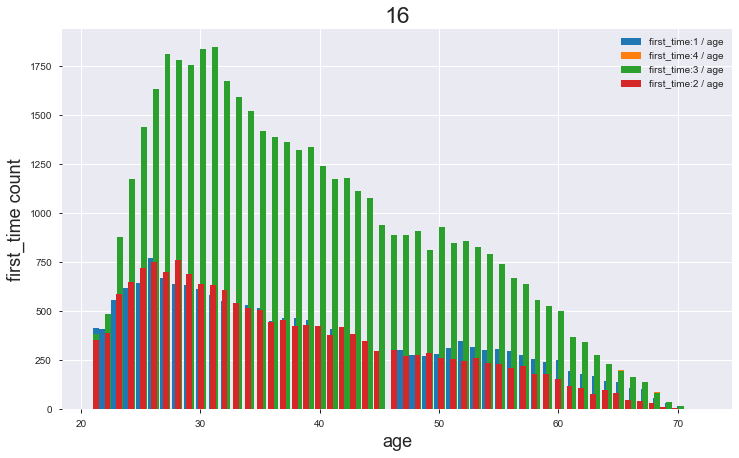

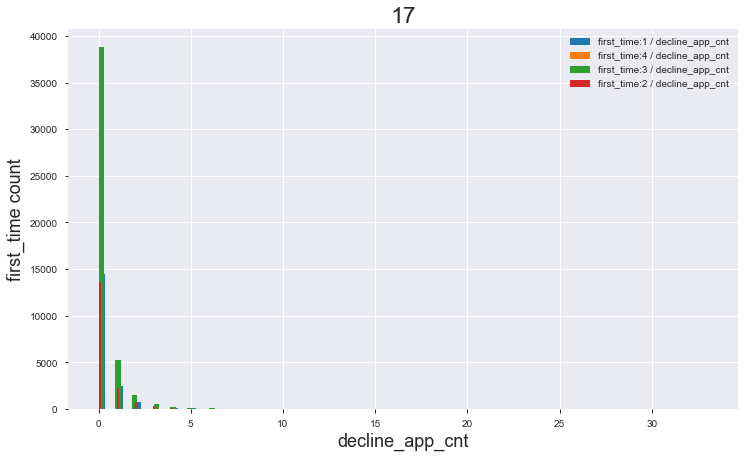

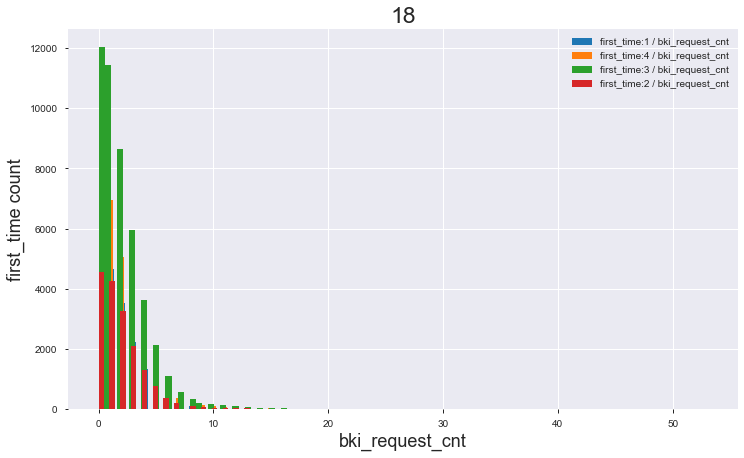

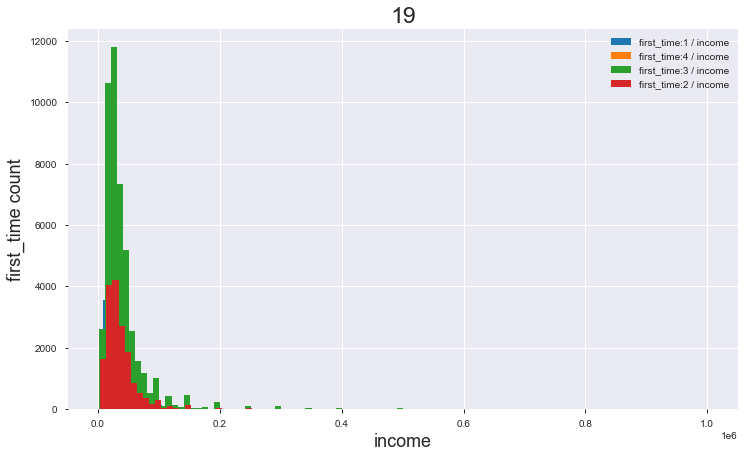

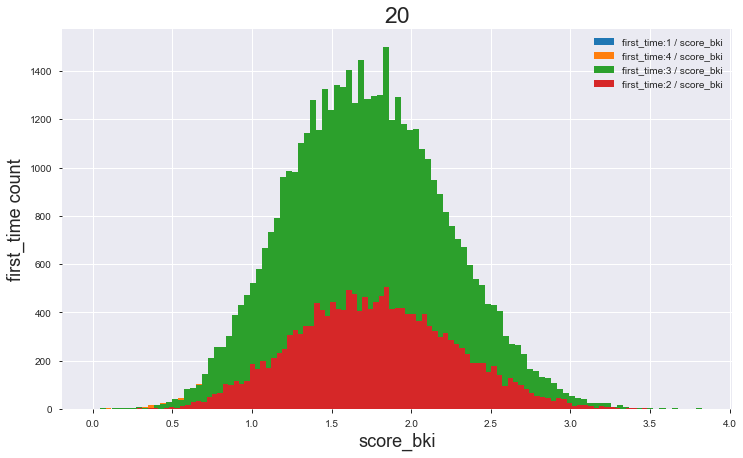

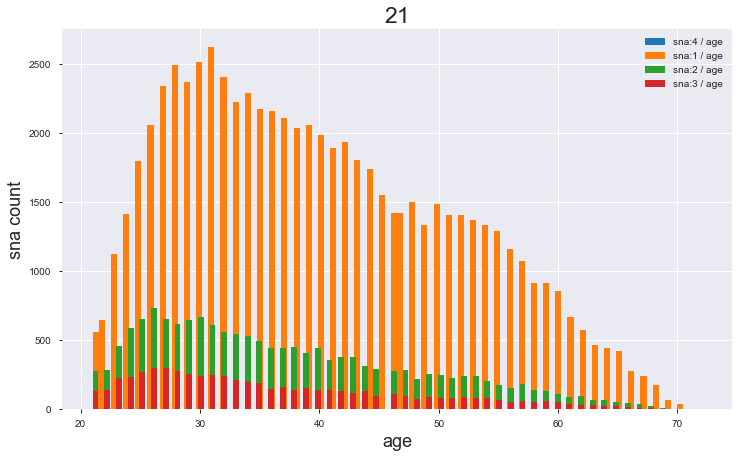

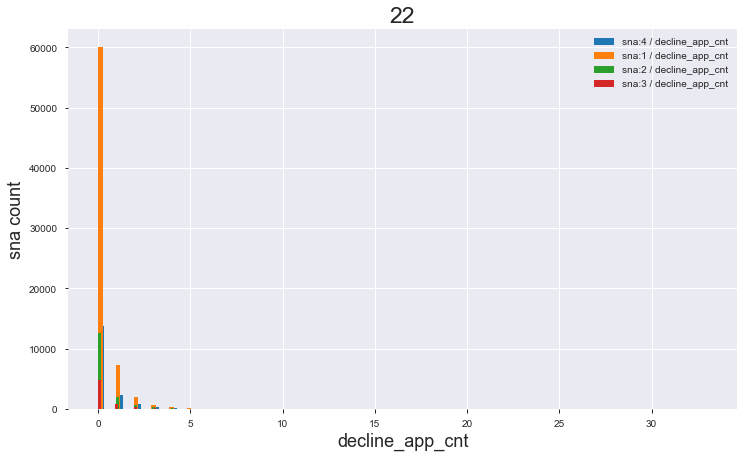

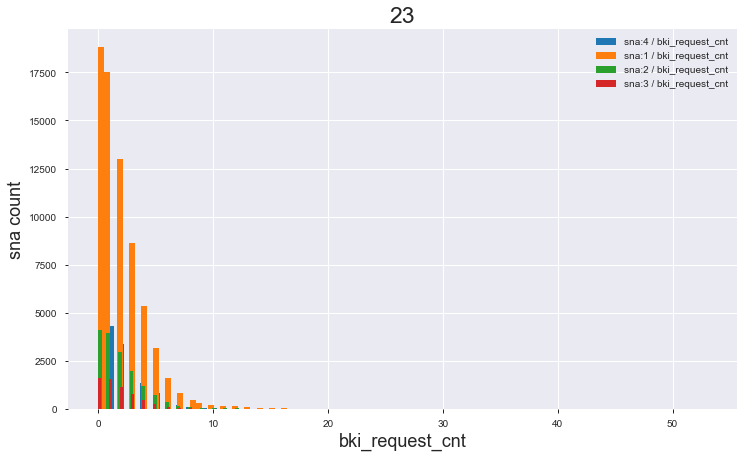

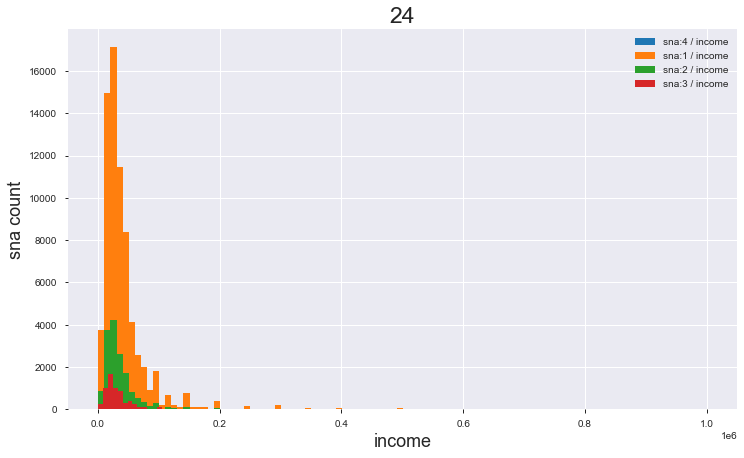

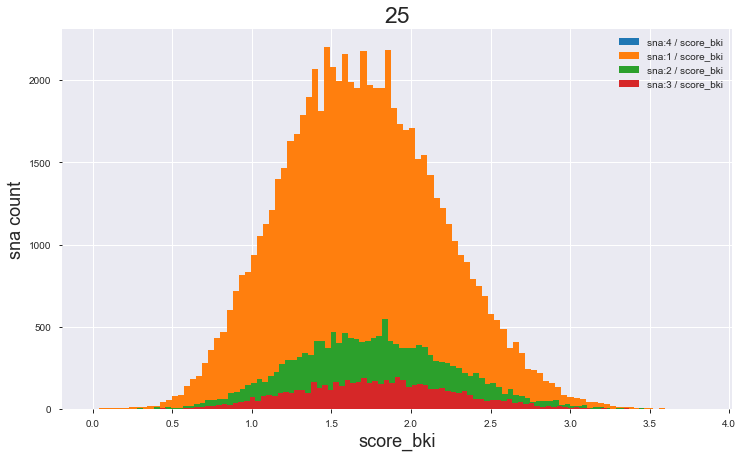

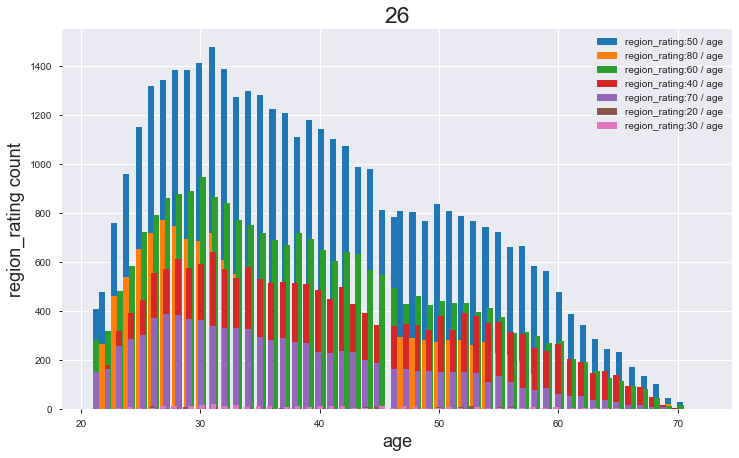

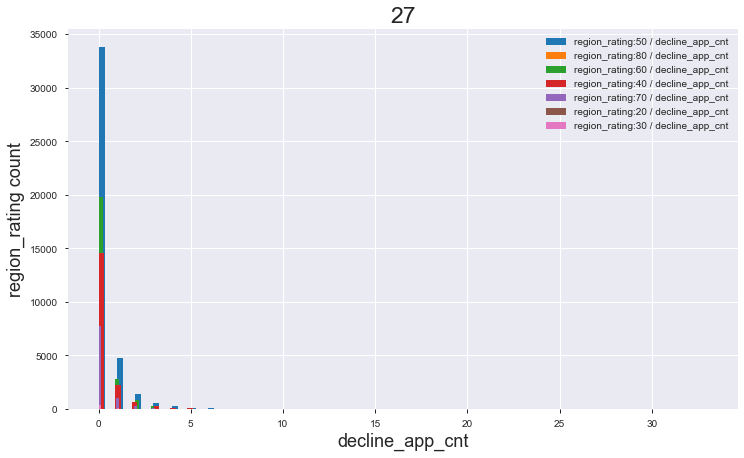

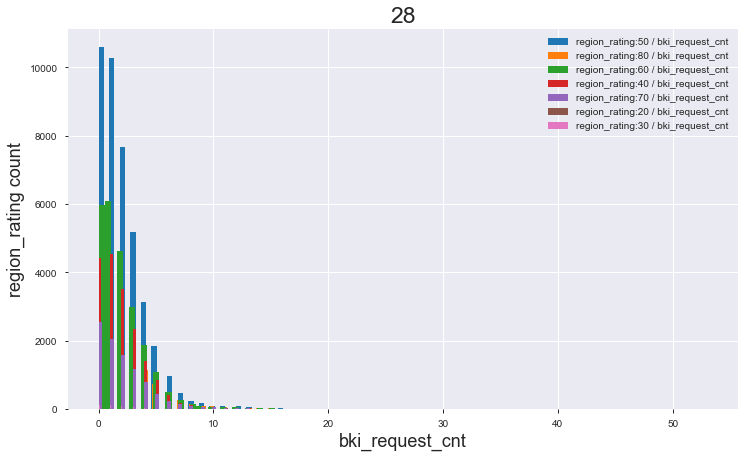

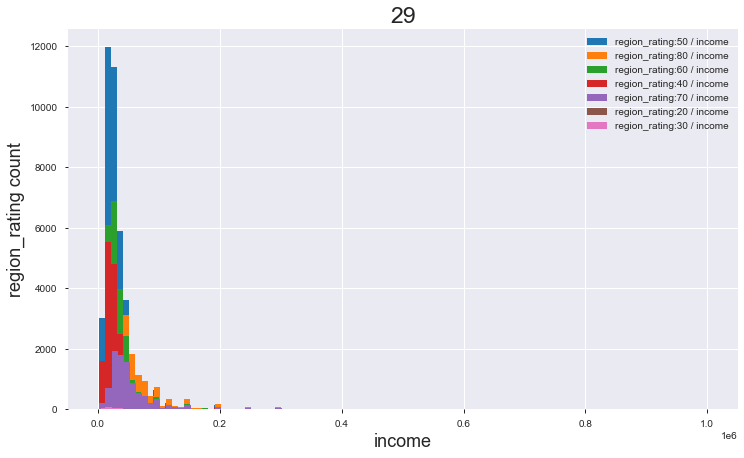

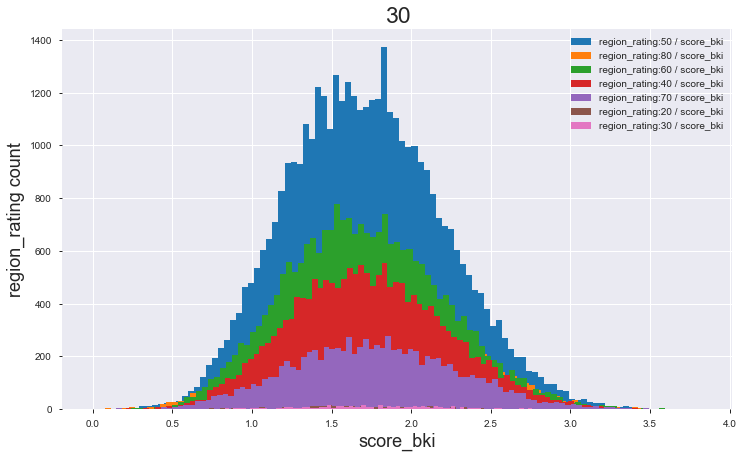

In [9]:
i = 1
for cat_col in cat_cols:
    for num_col in num_cols:
        my_func.hist_cat_num(data, cat_col, num_col, i)
        i += 1

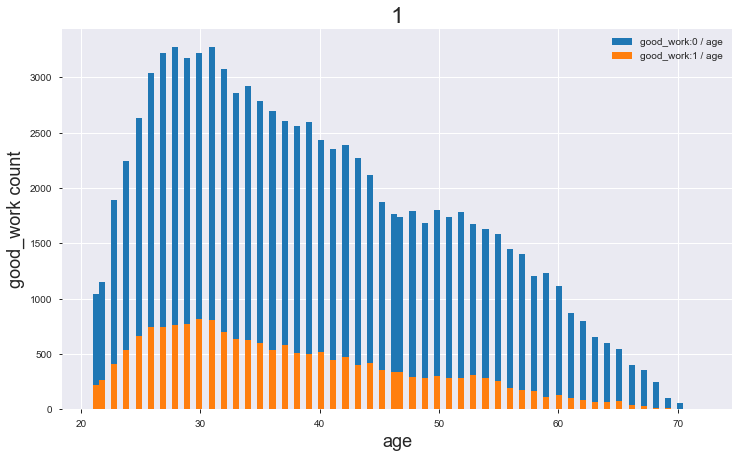

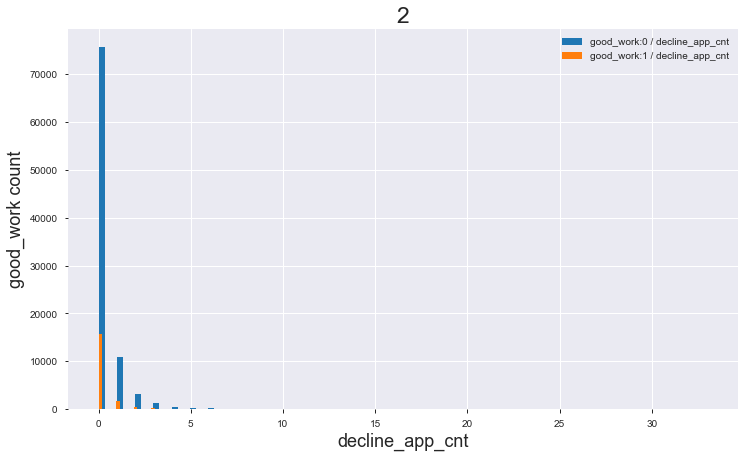

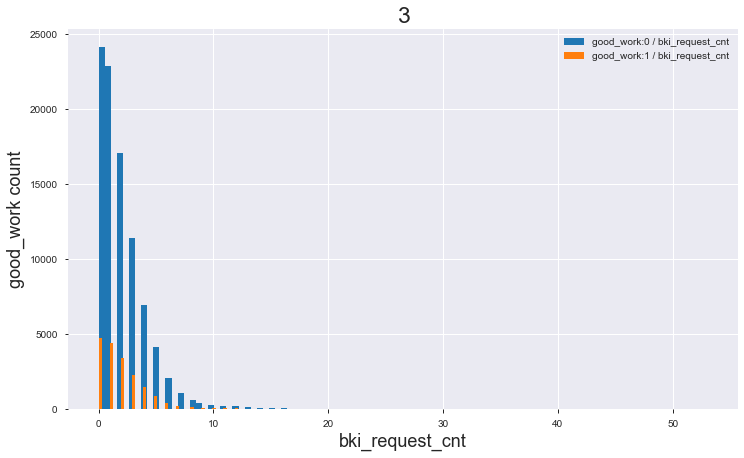

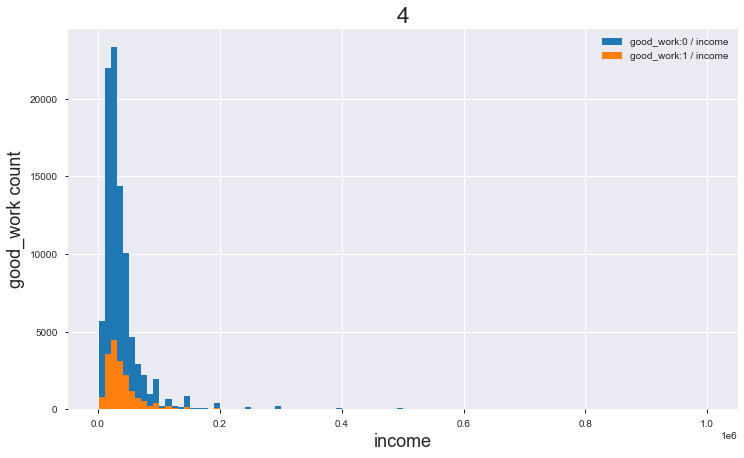

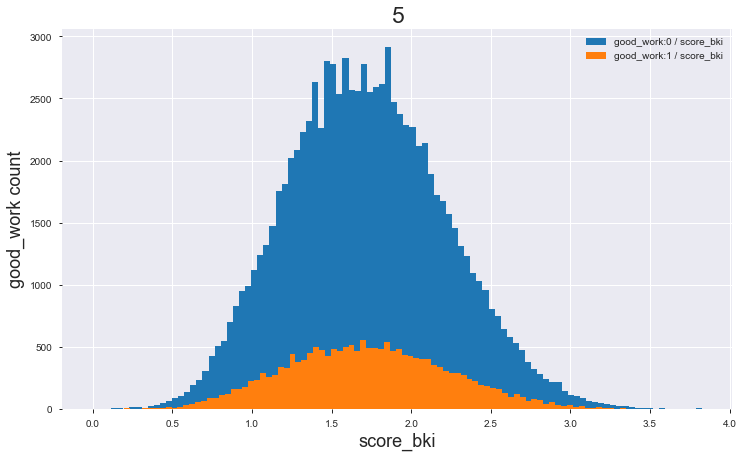

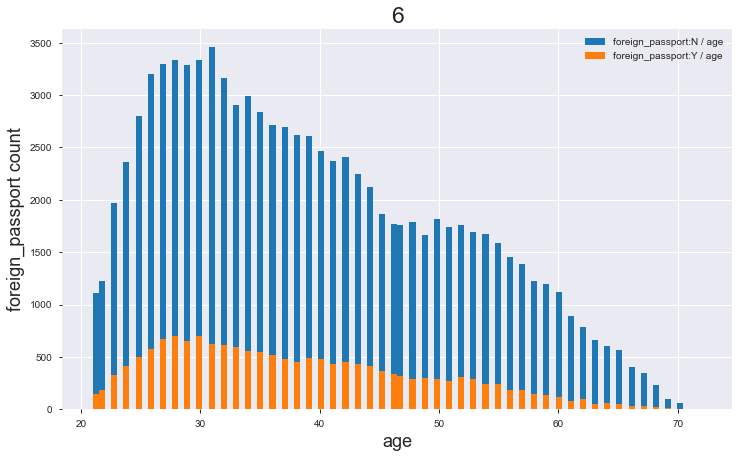

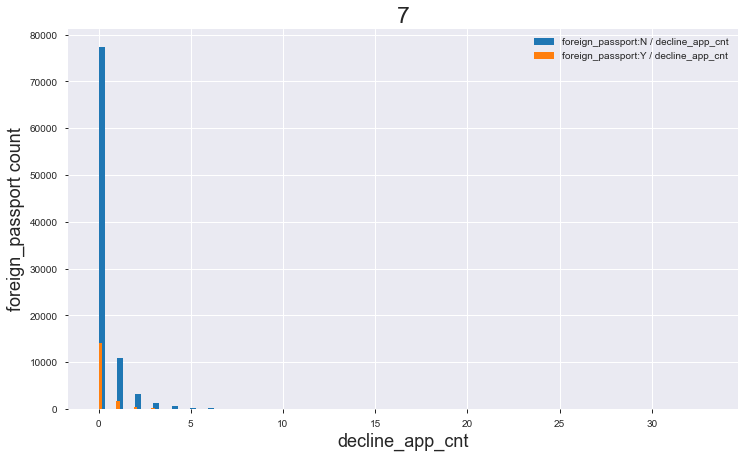

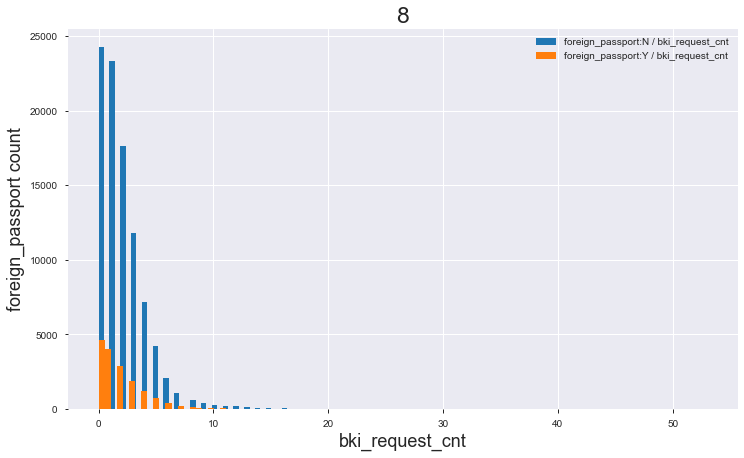

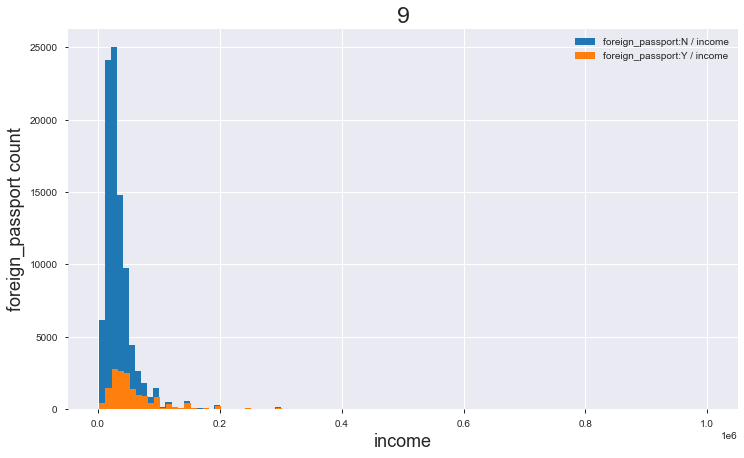

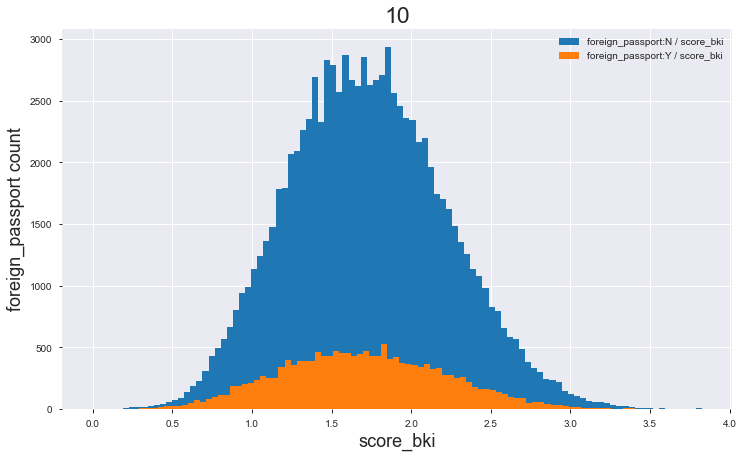

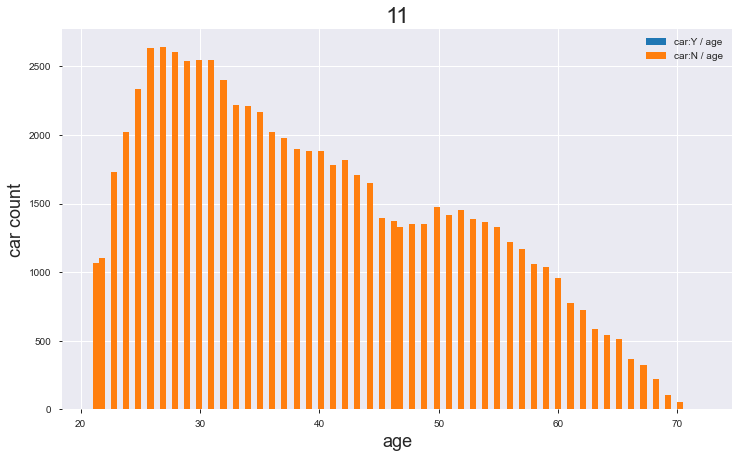

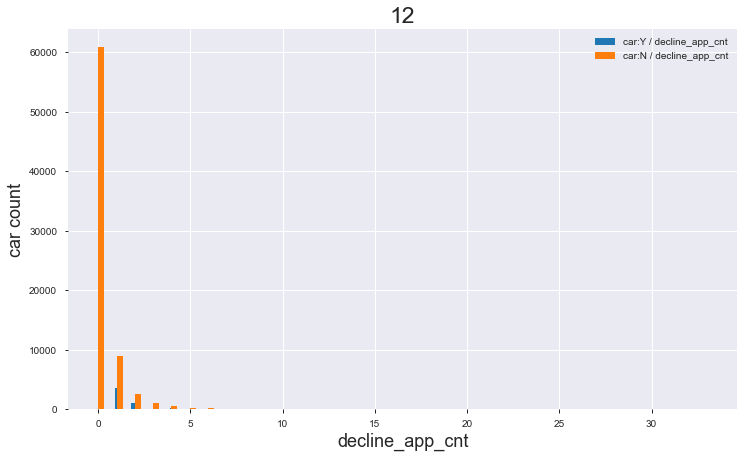

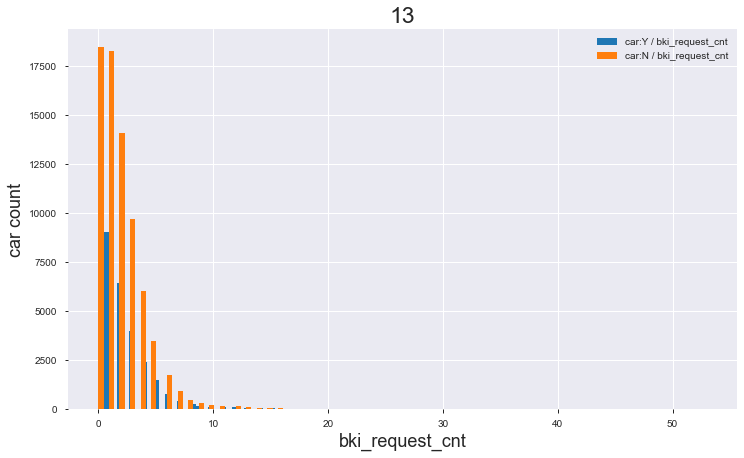

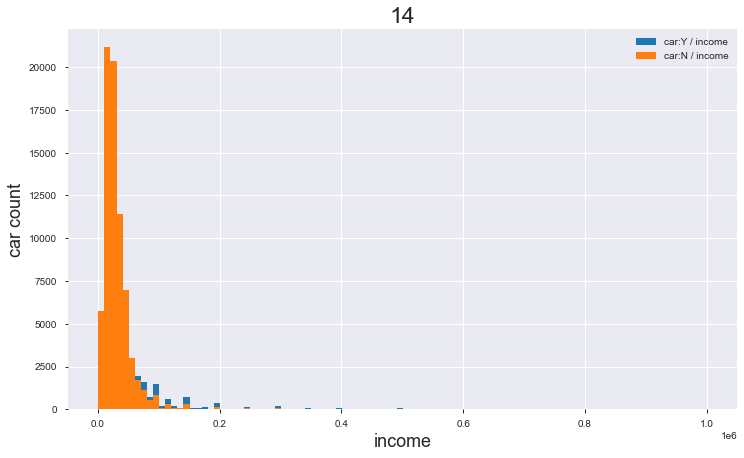

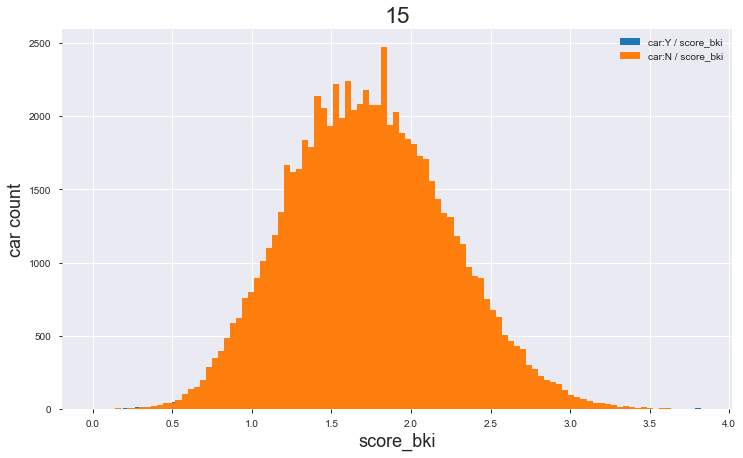

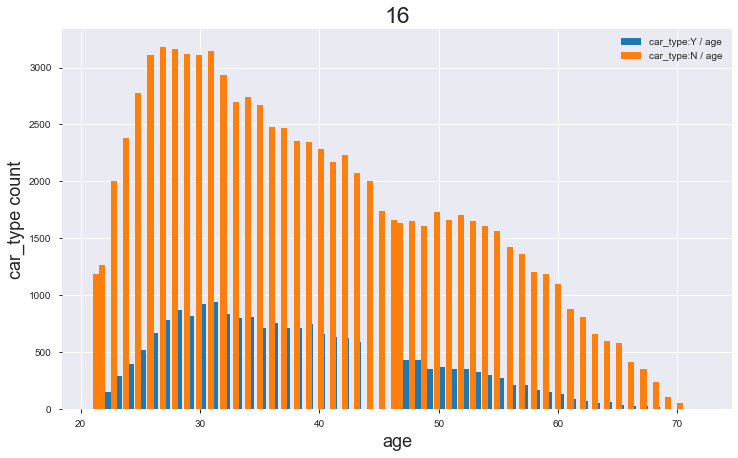

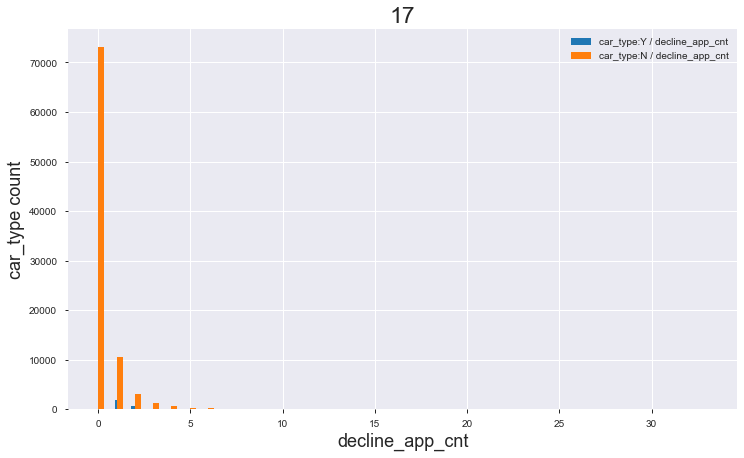

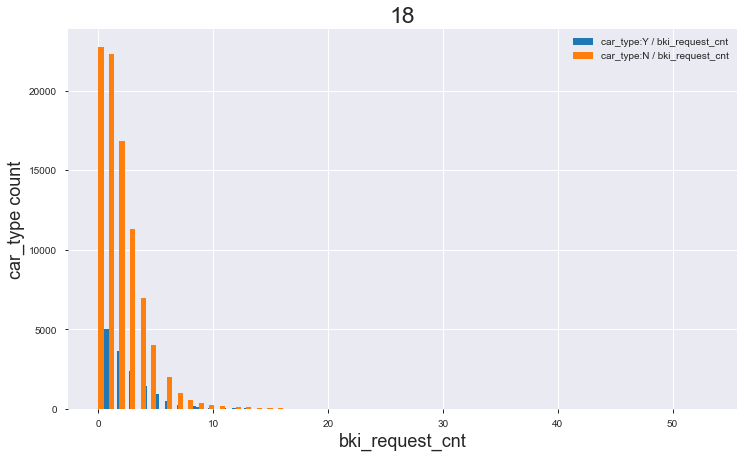

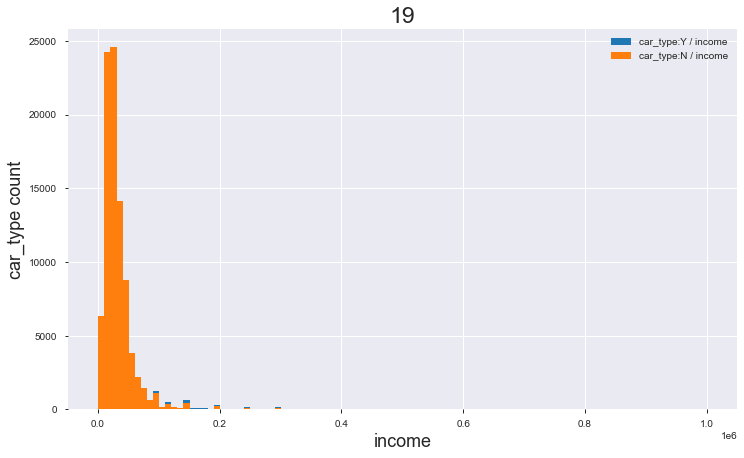

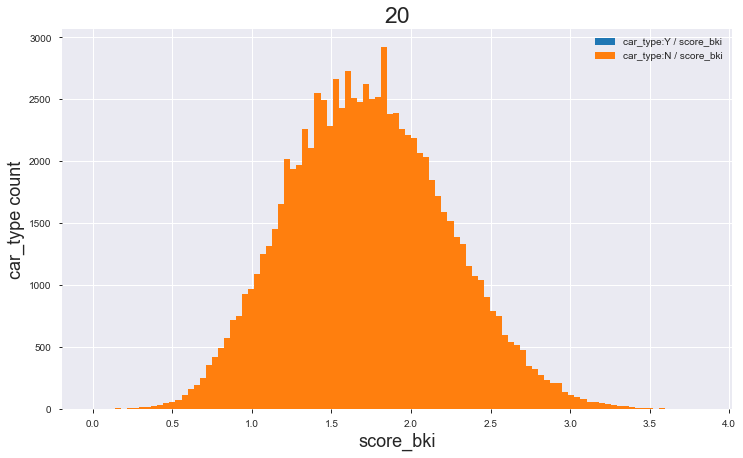

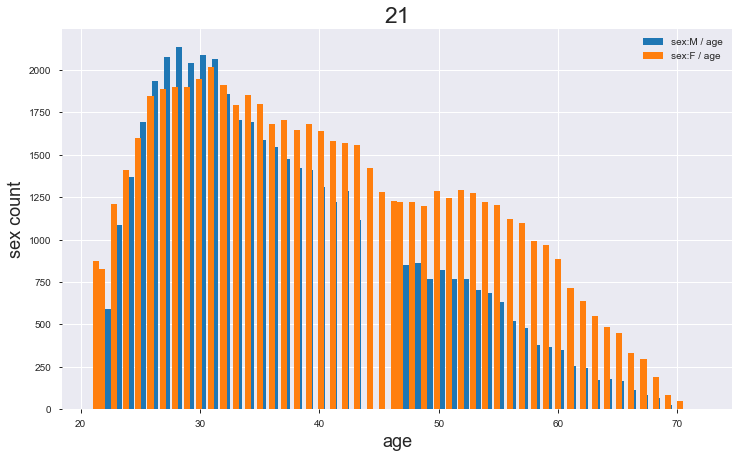

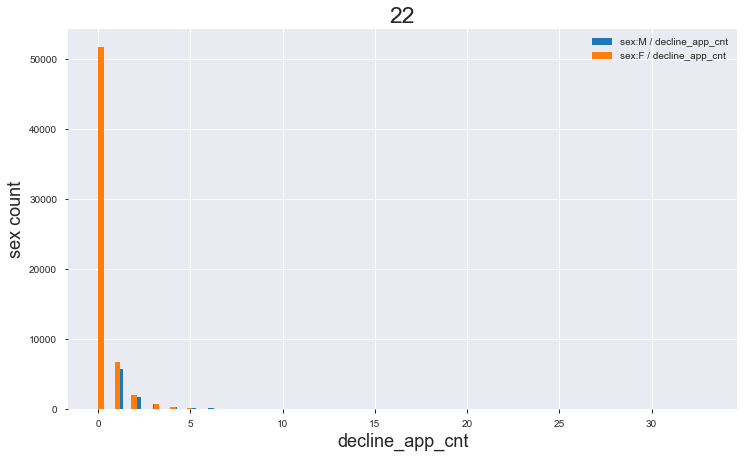

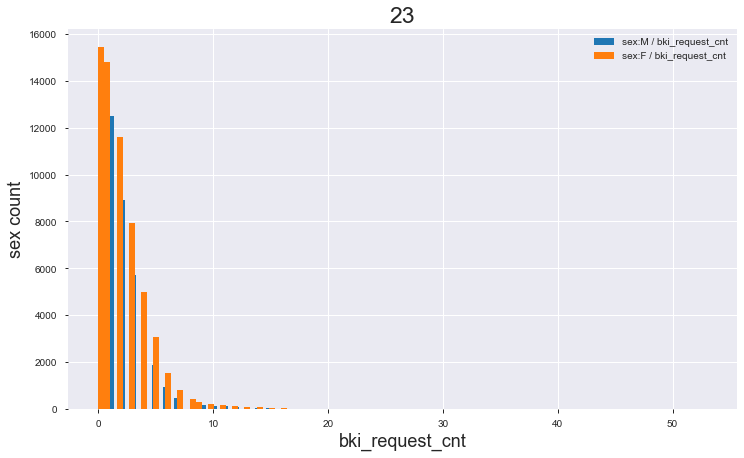

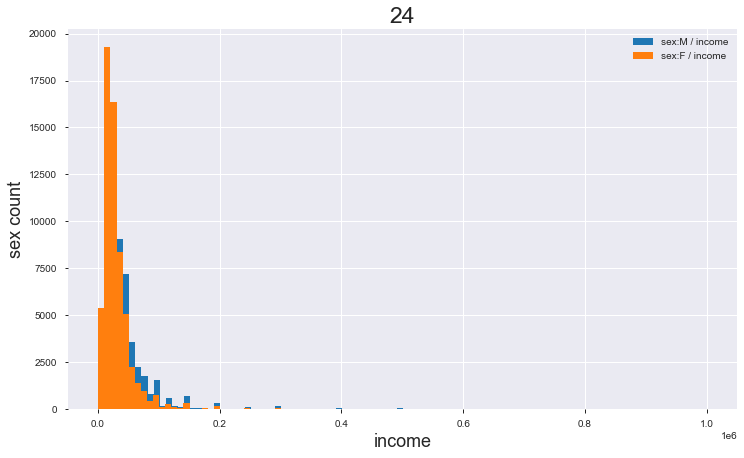

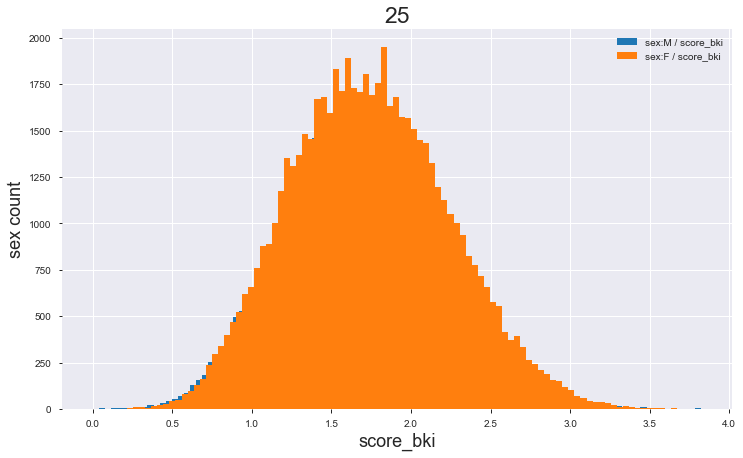

In [10]:
i = 1
for bin_col in bin_cols:
    for num_col in num_cols:
        my_func.hist_cat_num(data, bin_col, num_col, i)
        i += 1

In [ ]:
# data_train = pd.read_csv('kaggle/train.csv')
# data_test = pd.read_csv('kaggle/test.csv')
# data_train['train'] = 1 # помечаем где у нас трейн
# data_test['train'] = 0 # помечаем где у нас тест
# data = data_train.append(data_test, sort=False).reset_index(drop=True)
# bin_cols = ['good_work', 'foreign_passport', 'car', 'car_type', 'sex' ]
# num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki']
# cat_cols = ['education', 'home_address' , 'work_address', 'first_time', 'sna' , 'region_rating']
# data.score_bki = data.score_bki - data.score_bki.min() 
# edu_income_rel = dict({'SCH': list([0, 31960.275039]),
#                        'UGR': list([31960.275039,39391.796251]),
#                        'GRD': list([39391.796251, 54663.948941]),
#                        'PGR': list([54663.948941, 77548.206046]),
#                        'ACD': list([77548.206046, 999999999999])})
# def fill_edu(income, edu_income_rel):
#     for edu, income_edu in edu_income_rel.items():
#          if income_edu[0] < income <  income_edu[1]:
#              return edu
# na_index = data[data.education.isna()].index
# data['education_isNAN'] = pd.isna(data.education).astype('uint8')
# for index in na_index:
#     inc = data.income.iloc[index]
#     data.education.iloc[index] = fill_edu(inc, edu_income_rel)

In [ ]:
for_plot = data.groupby(by='car_type')['default'].mean()
# for_plot.foreign_passport.plot.bar()
# for_plot.income.plot.bar()
for_plot

In [ ]:
for_plot = data.groupby(by='default')[num_cols].mean()
for_plot.age.plot.bar()
for_plot.income.plot.bar()
for_plot

In [ ]:
plt.figure(figsize=(15,5))
data.groupby('bki_request_cnt').default.mean().plot.bar()


In [ ]:
for_plot = data.groupby(by=['car_type', 'car'])['income', 'default'].mean().reset_index()
for_plot['car_type'] =  for_plot['car_type'] + for_plot['car']
for_plot.car_type = for_plot.car_type.apply(lambda x: 'no car' if x==0 else 
                                                      'common car' if x==1 else 
                                                      'foreign car')
for_plot.drop('car', axis=1, inplace=True)

plt.bar(x=for_plot.car_type, height=for_plot.default)
plt.title('дефолт \ марка машины')
for_plot

In [ ]:
plt.bar(x=for_plot.car_type, height=for_plot.income)
# plt.title('доход \ марка машины')

Вывод: с господами с иномарками реже случается дефолт, так же они в среднем довольно больше зарабатывают

In [ ]:
for_plot = data.groupby(by=['home_address'])['income', 'default'].mean()
plt.bar(x=for_plot.index, height=for_plot.income)
# plt.title('доход \ категория домашнего адреса')

In [ ]:
plt.bar(x=for_plot.index, height=for_plot.default)
# plt.title('дефолт \ категория домашнего адреса')

Вывод: Дефолтные юниты проживающие во второй категории встречаются чаще.